In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
from tools.model import Unet

In [ ]:
model = Unet().to('cuda')

In [ ]:
checkpoint = torch.load('/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_notebooks/cnn/model_piunet_opt_b3_elr/model_10001.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [ ]:
inputs = np.load('data/inputs_11158.npy')
outputs = np.load('data/outputs_11158.npy')

In [ ]:
inputs = torch.Tensor(inputs).to('cuda')
labels = outputs

inputs.shape, labels.shape

(torch.Size([66, 3, 513, 257, 1]), (66, 3, 513, 257, 50))

In [ ]:
model_input = torch.permute(inputs, (0, 4, 3, 2, 1))
model_input.shape

torch.Size([66, 1, 257, 513, 3])

In [ ]:
b_norm = 2500

In [ ]:
N = model_input.shape[0]
N

66

In [ ]:
bs = []
for i in range(N):
    model_input[i].shape
    b = model(model_input[i][None, ...])
    b = b.cpu().detach().numpy().transpose(0, 3, 2, 1, 4)*b_norm
    bs.append(b)
bs = np.array(bs)
bs.shape

(66, 1, 513, 257, 50, 3)

In [ ]:
bs = bs[:, 0, ...]
bs.shape

(66, 513, 257, 50, 3)

In [ ]:
b2 = (bs**2).sum(-1).sum((1, 2, 3))
b2.shape

(66,)

In [ ]:
b2[0]

74240790000.0

In [ ]:
labels.shape

(66, 3, 513, 257, 50)

In [ ]:
B2 = ((labels*b_norm)**2).sum(1).sum((1, 2, 3))
B2.shape

(66,)

In [ ]:
B2[0]

80785965000.0

In [ ]:
eps = b2/B2 
eps[0]

0.91898125

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

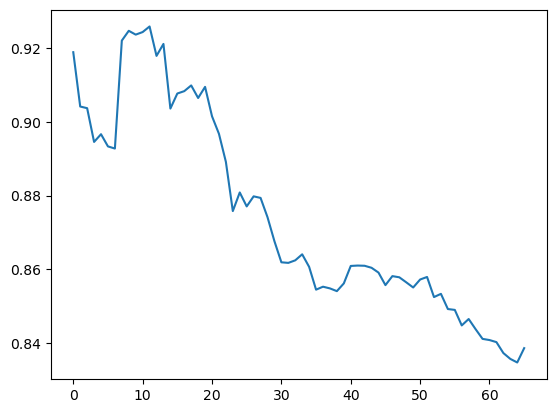

In [ ]:
plt.plot(eps)

In [ ]:
outputs_pot = np.load('data/outputs_pot_11158.npy')

In [ ]:
outputs_pot.shape

(66, 3, 513, 257, 50)

In [ ]:
Bpot2 = ((outputs_pot*b_norm)**2).sum(1).sum((1, 2, 3))
Bpot2.shape

(66,)

In [ ]:
Bpot2[0]

66449002000.0

<matplotlib.legend.Legend>

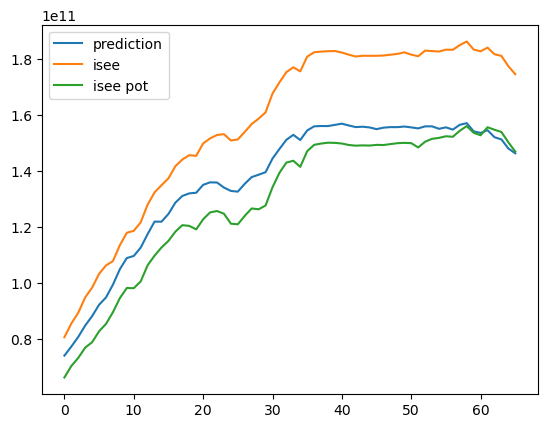

In [ ]:
plt.plot(b2, label='prediction')
plt.plot(B2, label='isee')
plt.plot(Bpot2, label='isee pot')
plt.legend()

<matplotlib.legend.Legend>

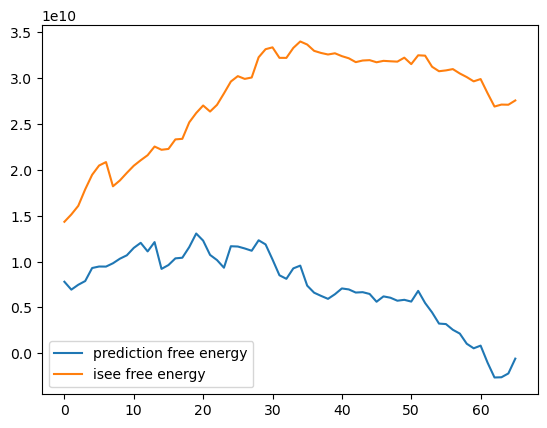

In [ ]:
plt.plot(b2-Bpot2, label='prediction free energy')
plt.plot(B2-Bpot2, label='isee free energy')
plt.legend()

In [ ]:
b = bs[0]
B = labels[0].transpose(1, 2, 3, 0)*b_norm
b.shape, B.shape

((513, 257, 50, 3), (513, 257, 50, 3))

In [ ]:
from tools.ploting import plot_overview
from tools.metric import evaluate
from tools.metric_another import metrics

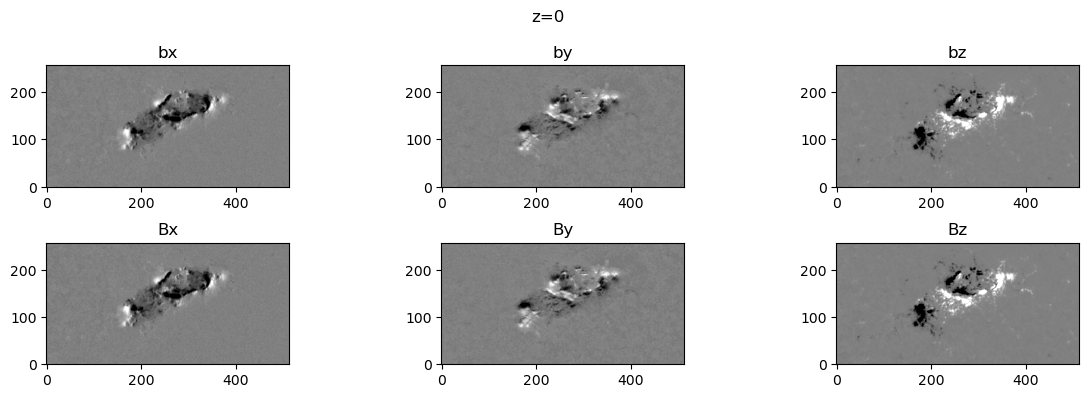

In [ ]:
plot_overview(b, B, z=0, b_norm=1000)

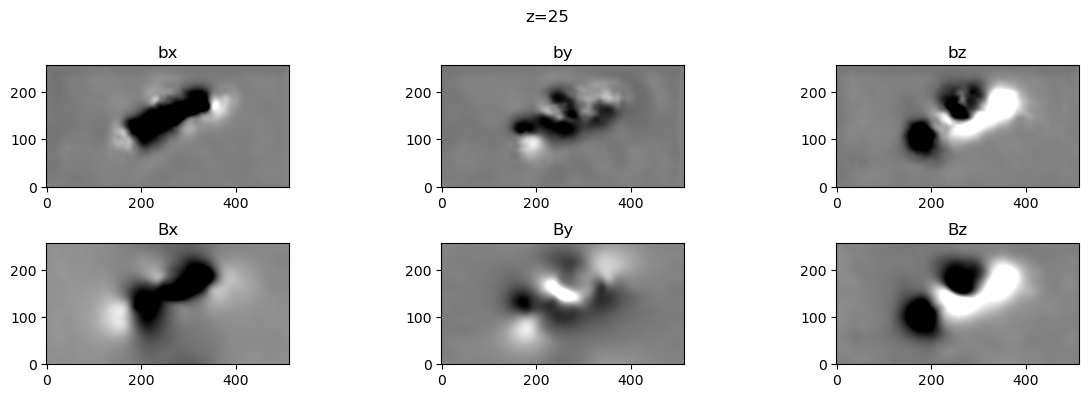

In [ ]:
plot_overview(b, B, z=25, b_norm=100)

In [ ]:
evaluate(b, B)

/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:58: RuntimeWarning: invalid value encountered in divide
  result['C_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:63: RuntimeWarning: divide by zero encountered in divide
  E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:76: RuntimeWarning: invalid value encountered in divide
  result['sig_J_1e2_B'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:81: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'C_vec': 0.9321719,
 'C_cs': nan,
 "E_n'": 0.46120214462280273,
 "E_m'": -inf,
 'eps': 0.91898125,
 'sig_J_1e2': 81.9413361456289,
 'sig_J_1e2_B': nan,
 'L1': 127.813866,
 'L2': 78.78834,
 'L1_B': nan,
 'L2_B': 54.976227,
 'L2n': 16.44609421491623,
 'L2n_B': 458290650.0}

In [ ]:
metrics(b, B)

{'c_vec': 0.9321719,
 'c_cs': 0.40549445923498756,
 'c_cs_ep': 0.3691865580509856,
 "E_n'": 0.46120214462280273,
 "E_m'": 0.08251522667455502,
 "E_m'_ep": -363078.96823082346,
 'eps': 0.91898125}